In [1]:
!pip install yfinance
!pip install finta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/ChatGPT-AI-InvestmentAdvisor/')

Mounted at /content/drive


[*********************100%***********************]  1 of 1 completed


100%|██████████| 1197/1197 [00:01<00:00, 902.20it/s]


38/38 [==============================] - 0s 2ms/step


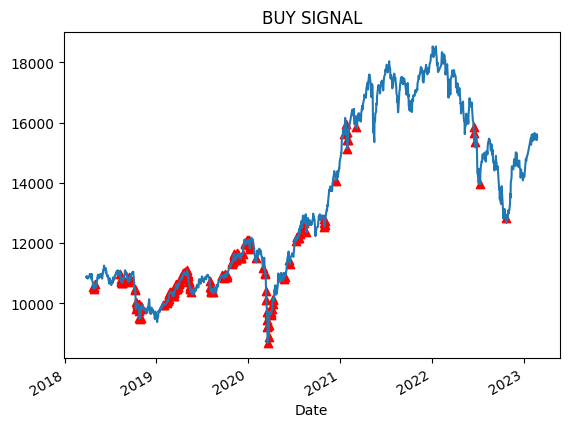

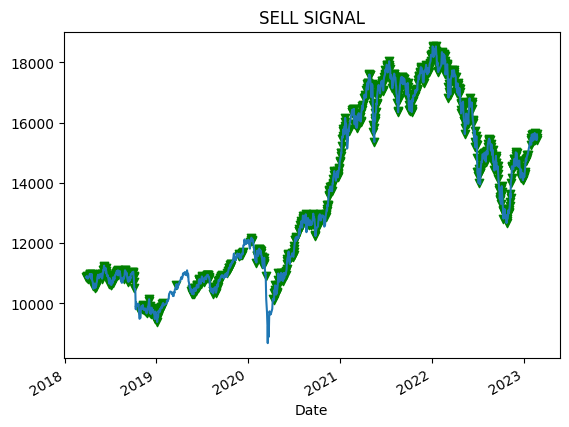

買入時間: 2018-01-25 00:00:00
買入價格: 11165.9501953125
賣出時間: 2018-01-31 00:00:00
賣出價格: 11103.7900390625
獲利: -5532.25390625
買入時間: 2018-05-25 00:00:00
買入價格: 10942.2998046875
賣出時間: 2018-06-07 00:00:00
賣出價格: 11251.75
獲利: 27850.517578125
買入時間: 2018-06-28 00:00:00
買入價格: 10654.2802734375
賣出時間: 2018-07-05 00:00:00
賣出價格: 10611.8095703125
獲利: -4034.716796875
買入時間: 2018-07-23 00:00:00
買入價格: 10946.8896484375
賣出時間: 2018-08-06 00:00:00
賣出價格: 11024.099609375
獲利: 7180.5263671875
買入時間: 2018-08-07 00:00:00
買入價格: 10983.4404296875
賣出時間: 2018-08-17 00:00:00
賣出價格: 10690.9599609375
獲利: -27200.68359375
買入時間: 2018-11-12 00:00:00
買入價格: 9831.2099609375
賣出時間: 2018-12-03 00:00:00
賣出價格: 10137.8701171875
獲利: 30972.67578125
買入時間: 2018-12-04 00:00:00
買入價格: 10083.5400390625
賣出時間: 2018-12-06 00:00:00
賣出價格: 9684.7197265625
獲利: -40679.671875
買入時間: 2018-12-07 00:00:00
買入價格: 9760.8798828125
賣出時間: 2018-12-20 00:00:00
賣出價格: 9674.51953125
獲利: -8722.3955078125
買入時間: 2018-12-21 00:00:00
買入價格: 9676.669921875
賣出時間: 2019-01-04 00:00:00
賣

In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt
from finta import TA
from tqdm import tqdm

# 下載台灣加權指數資料
ticker = '^TWII'
start_date = '2018-01-01'#從訓練資料沒有包括的時間開始做回測
end_date = '2023-02-26'#設置回測結束日期
df = yf.download(ticker, start=start_date, end=end_date)

# 載入Model和Scaler
model = load_model('/content/drive/MyDrive/ChatGPT-AI-InvestmentAdvisor/model_cnn_15_3.h5')
with open('/content/drive/MyDrive/ChatGPT-AI-InvestmentAdvisor/scaler_3.pkl', 'rb') as f:
    scaler = pickle.load(f)

# 此函數參考至CHATGPT:https://sharegpt.com/c/CTyoQQ2
def calculate_ta(df):
    ta_functions = [TA.SMA, TA.EMA, TA.STOCH, TA.TEMA, TA.STOCHD, TA.RSI, TA.STOCHRSI, TA.OBV, TA.MACD, TA.PPO, TA.ROC, TA.DMI, TA.ADX, TA.ATR, TA.MOM]
    ta_names = ['SMA','EMA','K','TEMA','D','RSI','STOCHRSI','OBV','MACD','PPO','ROC','DMI','ADX','ATR','MOM']
    for i, ta_func in enumerate(ta_functions):
        try:
            df[ta_names[i]] = ta_func(df)
        except:
            if ta_names[i] == 'MACD':
                df[ta_names[i]] = ta_func(df)['MACD']-ta_func(df)['SIGNAL']
            if ta_names[i] == 'PPO':
                df[ta_names[i]] = ta_func(df)['PPO']-ta_func(df)['SIGNAL']
            if ta_names[i] == 'DMI':
                df[ta_names[i]] = ta_func(df)['DI+']-ta_func(df)['DI-']
    return df

# 輸入股價資料,scaler,model,輸出(0,1,2)等買進賣出訊號
def process(df,scaler,model):
    # 特徵工程
    df = calculate_ta(df)
    df = df.dropna(axis=0)
    features = df.columns[-15:].tolist()
    Close = df[['Close']]
    df = df[features]

    # 數值轉換
    df[features] = scaler.transform(df[features])

    # 製作X
    days = 15
    start_index = 0
    end_index = len(df)-days
    Xs = []
    indexs = []
    for i in tqdm(range(start_index ,end_index+1 ,1)):
        X = df.iloc[i:i+days,:][features]
        X = np.array(X)
        Xs.append(X)
        indexs.append((df.iloc[[i]].index,df.iloc[[i+days-1]].index))
    Xs = np.array(Xs)

    # 模型預測
    answer = model.predict(Xs)
    answer = [ np.argmax(i) for i in answer]

    # 繪製圖表
    Close = Close.iloc[-len(Xs):,:]
    Close['SIGNAL'] = answer
    buy = Close[Close['SIGNAL']==1]['Close']
    sell = Close[Close['SIGNAL']==2]['Close']
    Close['Close'].plot()
    plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
    plt.title('BUY SIGNAL')
    plt.show()
    Close['Close'].plot()
    plt.scatter(list(sell.index),list(sell.values),color='green',marker='v')
    plt.title('SELL SIGNAL')
    plt.show()

    return answer,Close.index

# 回測框架參考自CHATGPT
# https://shareg.pt/wQwSsaA
'''
我希望請你做代碼補全的工作規則如下:
1.#字號後面為註解
2.<you codeing here> 代表要請你輸入代碼
以下是第一個我請你幫忙補全的代碼:
def backtest(df, model, scaler,ub,lb,t):
    signals = process(df,scaler,model) #signals是一個list元素有0,1,2分別代表pass,buy,sell
    df = df.tail(len(signals)) #dataframe代表股價歷史資料
    # 以下請幫我對df做遍歷根據signals進行BUY跟SELL來做模擬交易回測
    # 其中止盈賣出價格 = 進場價格*ub, 止損價格 = 進場價格*lb
    # 當持有時間超過t個時間點也需要將股票賣出
    <you codeing here>
'''

signals,index = process(df,scaler,model)
capital = 1000000  # 初始資本
hold = False  # 是否持有股票
entry_price = 0  # 進場價格
entry_idx = 0  # 進場時間點
exit_price = 0  # 出場價格
exit_idx = 0  # 出場時間點
t = 20
lb = 0.97
ub = 1.03
capital_history = []
for i, signal in enumerate(signals):
    if signal == 1 and not hold:  # 進場買入
        hold = True
        entry_price = df.iloc[i]['Close']
        entry_idx = i
    elif signal == 2 and hold:  # 出場賣出
        hold = False
        exit_price = df.iloc[i]['Close']
        exit_idx = i
        # 計算交易結果
        shares = capital // entry_price
        profit = shares * (exit_price - entry_price)
        capital += profit
        print('買入時間:', df.index[entry_idx])
        print('買入價格:', entry_price)
        print('賣出時間:', df.index[exit_idx])
        print('賣出價格:', exit_price)
        print('獲利:', profit)
    elif hold and (i - entry_idx >= t or df.iloc[i]['Close'] <= entry_price * lb or df.iloc[i]['Close'] >= entry_price * ub):  # 到達出場條件
        hold = False
        exit_price = df.iloc[i]['Close']
        exit_idx = i
        # 計算交易結果
        shares = capital // entry_price
        profit = shares * (exit_price - entry_price)
        capital += profit
        print('買入時間:', df.index[entry_idx])
        print('買入價格:', entry_price)
        print('賣出時間:', df.index[exit_idx])
        print('賣出價格:', exit_price)
        print('獲利:', profit)
    capital_history.append(capital)

最終報酬率:+25.70561650390626%
最大虧損:-4.987617773437503%


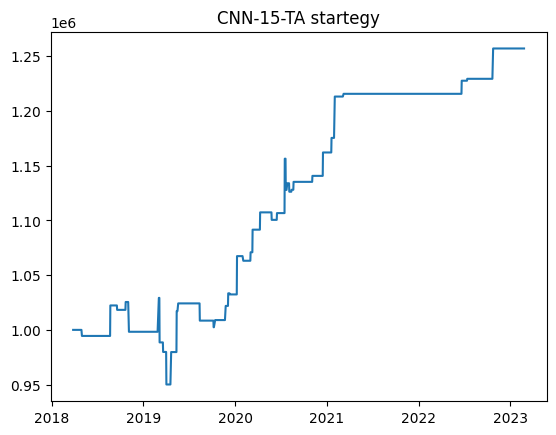

In [7]:
plt.plot(index,capital_history)
plt.title('CNN-15-TA startegy')
print(f"最終報酬率:+{(capital_history[-1]/capital_history[0]-1)*100}%")
print(f"最大虧損:{-(1-min(capital_history)/capital_history[0])*100}%")

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dropout (Dropout)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 3)                 3